# 🧪 Laboratorio 7
Integrantes
- Diego Alexander Hernández Silvestre - 21270
- Linda Inés Jiménez Vides - 21169
- Mario Antonio Guerra Morales - 21008
- Kristopher Javier Alvarado López - 21188

## 💻 Task 1

### 📚 Librerías

In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import imageio
from IPython.display import Image, display

### 🌐 Entorno CartPole

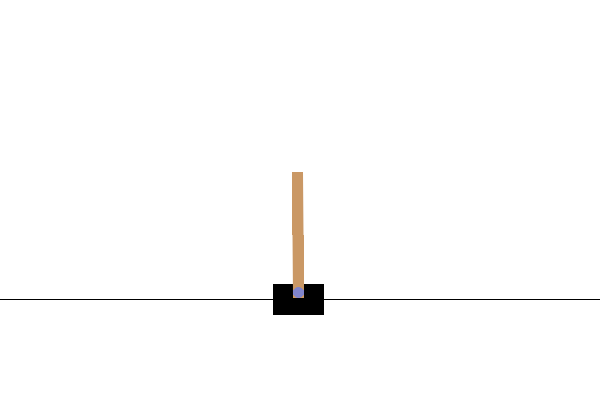

In [2]:


# Crear el entorno CartPole
env = gym.make('CartPole-v1', render_mode="rgb_array")

# Reiniciar el entorno
state, info = env.reset()

# Lista para almacenar los frames
frames = []

# Número de pasos máximos a ejecutar
num_steps = 500

# Loop para ejecutar los pasos en el entorno
for step in range(num_steps):
    # Renderizar el entorno y capturar el frame
    frame = env.render()
    frames.append(frame)

    # Seleccionar una acción: hacia la derecha si el ángulo del poste es negativo, izquierda si es positivo
    action = 0 if state[2] < 0 else 1  # Política simple basada en el ángulo del poste
    
    # Realizar la acción en el entorno
    next_state, reward, done, truncated, info = env.step(action)
    
    # Si el episodio ha terminado, reiniciar el entorno
    if done or truncated:
        state, info = env.reset()
    else:
        state = next_state

# Cerrar el entorno
env.close()

# Guardar el GIF en un archivo
gif_filename = 'data/cartpole_simulation.gif'
imageio.mimsave(gif_filename, frames, fps=30, loop=0)

# Mostrar el GIF en la celda
display(Image(filename=gif_filename))


In [3]:


env = gym.make("CartPole-v1")

def Random_games():
    # Each of this episode is its own game.
    for episode in range(10):
        env.reset()
        # this is each frame, up to 500...but we wont make it that far with random.
        for t in range(500):
            # This will display the environment
            # Only display if you really want to see it.
            # Takes much longer to display it.
            env.render()
            
            # This will just create a sample action in any environment.
            # In this environment, the action can be 0 or 1, which is left or right
            action = env.action_space.sample()

            # this executes the environment with an action, 
            # and returns the observation of the environment, 
            # the reward, if the env is over, and other info.
            next_state, reward, done, truncated, info = env.step(action)
            
            # lets print everything in one line:
            print(t, next_state, reward, done, truncated, info, action)
            if done or truncated:
                break
                
Random_games()

0 [ 0.02167965 -0.18088427  0.04059044  0.30985576] 1.0 False False {} 0
1 [ 0.01806197 -0.37656033  0.04678756  0.6150584 ] 1.0 False False {} 0
2 [ 0.01053076 -0.18212228  0.05908873  0.337471  ] 1.0 False False {} 1
3 [0.00688832 0.01211123 0.06583815 0.06399121] 1.0 False False {} 1
4 [ 0.00713054 -0.18388987  0.06711797  0.37669832] 1.0 False False {} 0
5 [ 0.00345275 -0.3798977   0.07465194  0.689766  ] 1.0 False False {} 0
6 [-0.00414521 -0.5759719   0.08844726  1.0049853 ] 1.0 False False {} 0
7 [-0.01566465 -0.77215666  0.10854696  1.3240818 ] 1.0 False False {} 0
8 [-0.03110778 -0.96846926  0.1350286   1.6486678 ] 1.0 False False {} 0
9 [-0.05047717 -0.7751597   0.16800195  1.4009207 ] 1.0 False False {} 1
10 [-0.06598036 -0.97192323  0.19602038  1.7410712 ] 1.0 False False {} 0
11 [-0.08541882 -1.1686629   0.2308418   2.0877907 ] 1.0 True False {} 0
0 [ 0.00895482  0.21396764 -0.00484436 -0.26401886] 1.0 False False {} 1
1 [ 0.01323417  0.4091584  -0.01012474 -0.5582258 ] 1.

c:\Users\Alvar\OneDrive\Documentos\SemestreVIII\Deep Learning\Lab07_DL\myenv\Lib\site-packages\gymnasium\envs\classic_control\cartpole.py:215: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(


In [7]:
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Definir redes
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
online_net = QNetwork(input_dim, output_dim)
target_net = QNetwork(input_dim, output_dim)

# Inicializar pesos de la red de destino con los de la red en línea
target_net.load_state_dict(online_net.state_dict())


<All keys matched successfully>

In [5]:
# Definición de hiperparámetros
gamma = 0.99  # Factor de descuento
epsilon = 1.0  # Parámetro de exploración inicial
epsilon_decay = 0.995  # Decaimiento de epsilon
epsilon_min = 0.01  # Valor mínimo de epsilon
lr = 0.001  # Tasa de aprendizaje
batch_size = 64  # Tamaño del batch
memory_size = 10000  # Tamaño de la memoria de experiencia
target_update_freq = 10  # Frecuencia de actualización de la red de destino


In [9]:
def epsilon_greedy_action(state, epsilon):
    if np.random.rand() <= epsilon:
        return env.action_space.sample()  # Exploración
    else:
        state = torch.FloatTensor(state).unsqueeze(0)
        q_values = online_net(state)
        return torch.argmax(q_values).item()  # Explotación

In [10]:
class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        experiences = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*experiences)
        return (np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones))

replay_buffer = ReplayBuffer(memory_size)

### 🏋🏽 Hiperparámetros y entrenamiento

In [15]:
# Ciclo de entrenamiento

# Definir el optimizador y la función de pérdida
optimizer = optim.Adam(online_net.parameters(), lr=lr)
loss_fn = nn.MSELoss()

# Número de episodios y pasos máximos por episodio
num_episodes = 1000
max_timesteps = 500

# Lista para almacenar las recompensas totales por episodio
total_rewards = []

for episode in range(num_episodes):
    state, _ = env.reset()
    total_reward = 0
    for t in range(max_timesteps):
        # Seleccionar una acción usando la política epsilon-greedy
        action = epsilon_greedy_action(state, epsilon)
        
        # Ejecutar la acción en el entorno
        next_state, reward, done, truncated, _ = env.step(action)
        total_reward += reward
        
        # Almacenar la experiencia en el buffer de reproducción
        replay_buffer.add((state, action, reward, next_state, done))
        
        # Actualizar el estado actual
        state = next_state
        
        # Si hay suficientes muestras en el buffer, realizar una actualización
        if len(replay_buffer.buffer) >= batch_size:
            # Muestrear un batch de experiencias
            states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
            
            # Convertir a tensores de PyTorch
            states = torch.FloatTensor(states)
            actions = torch.LongTensor(actions).unsqueeze(1)
            rewards = torch.FloatTensor(rewards)
            next_states = torch.FloatTensor(next_states)
            dones = torch.FloatTensor(dones)
            
            # Calcular los valores Q actuales
            q_values = online_net(states).gather(1, actions).squeeze(1)
            
            # Calcular los valores Q objetivo usando la red de destino
            with torch.no_grad():
                next_q_values = target_net(next_states).max(1)[0]
                targets = rewards + gamma * next_q_values * (1 - dones)
            
            # Calcular la pérdida
            loss = loss_fn(q_values, targets)
            
            # Retropropagación y actualización de pesos
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Si el episodio ha terminado, salir del loop
        if done or truncated:
            break
    
    # Almacenar la recompensa total obtenida en este episodio
    total_rewards.append(total_reward)
    
    # Decaimiento de epsilon
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay
    else:
        epsilon = epsilon_min
    
    # Actualizar la red de destino cada 'target_update_freq' episodios
    if episode % target_update_freq == 0:
        target_net.load_state_dict(online_net.state_dict())
    
    # Imprimir el progreso
    print(f"Episodio {episode}, Recompensa Total: {total_reward}, Epsilon: {epsilon:.4f}")



Episodio 0, Recompensa Total: 12.0, Epsilon: 0.9950
Episodio 1, Recompensa Total: 10.0, Epsilon: 0.9900
Episodio 2, Recompensa Total: 16.0, Epsilon: 0.9851
Episodio 3, Recompensa Total: 13.0, Epsilon: 0.9801
Episodio 4, Recompensa Total: 16.0, Epsilon: 0.9752
Episodio 5, Recompensa Total: 16.0, Epsilon: 0.9704
Episodio 6, Recompensa Total: 16.0, Epsilon: 0.9655
Episodio 7, Recompensa Total: 13.0, Epsilon: 0.9607
Episodio 8, Recompensa Total: 36.0, Epsilon: 0.9559
Episodio 9, Recompensa Total: 14.0, Epsilon: 0.9511
Episodio 10, Recompensa Total: 27.0, Epsilon: 0.9464
Episodio 11, Recompensa Total: 28.0, Epsilon: 0.9416
Episodio 12, Recompensa Total: 27.0, Epsilon: 0.9369
Episodio 13, Recompensa Total: 16.0, Epsilon: 0.9322
Episodio 14, Recompensa Total: 13.0, Epsilon: 0.9276
Episodio 15, Recompensa Total: 43.0, Epsilon: 0.9229
Episodio 16, Recompensa Total: 30.0, Epsilon: 0.9183
Episodio 17, Recompensa Total: 43.0, Epsilon: 0.9137
Episodio 18, Recompensa Total: 13.0, Epsilon: 0.9092
Epi

In [16]:
epsilon = 0.0
for episode in range(5):
    state, _ = env.reset()
    total_reward = 0
    for t in range(max_timesteps):
        action = epsilon_greedy_action(state, epsilon)
        next_state, reward, done, truncated, _ = env.step(action)
        total_reward += reward
        state = next_state
        if done or truncated:
            break
    print(f"Evaluación - Episodio {episode}, Recompensa Total: {total_reward}")


Evaluación - Episodio 0, Recompensa Total: 500.0
Evaluación - Episodio 1, Recompensa Total: 500.0
Evaluación - Episodio 2, Recompensa Total: 500.0
Evaluación - Episodio 3, Recompensa Total: 500.0
Evaluación - Episodio 4, Recompensa Total: 500.0


In [19]:
# Representar el entorno

env = gym.make('CartPole-v1', render_mode='human')

# Definir el optimizador y la función de pérdida
optimizer = optim.Adam(online_net.parameters(), lr=lr)
loss_fn = nn.MSELoss()

# Número de episodios y pasos máximos por episodio
num_episodes = 350
max_timesteps = 500

# Lista para almacenar las recompensas totales por episodio
total_rewards = []

for episode in range(num_episodes):
    # Controlar el renderizado: renderizar cada 100 episodios
    render = True if episode % 100 == 0 else False
    if render:
        print(f"Renderizando el episodio {episode}")

    state, _ = env.reset()
    total_reward = 0
    for t in range(max_timesteps):
        if render:
            env.render()

        # Seleccionar una acción usando la política epsilon-greedy
        action = epsilon_greedy_action(state, epsilon)
        
        # Ejecutar la acción en el entorno
        next_state, reward, done, truncated, _ = env.step(action)
        total_reward += reward
        
        # Almacenar la experiencia en el buffer de reproducción
        replay_buffer.add((state, action, reward, next_state, done))
        
        # Actualizar el estado actual
        state = next_state
        
        # Si hay suficientes muestras en el buffer, realizar una actualización
        if len(replay_buffer.buffer) >= batch_size:
            # Muestrear un batch de experiencias
            states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
            
            # Convertir a tensores de PyTorch
            states = torch.FloatTensor(states)
            actions = torch.LongTensor(actions).unsqueeze(1)
            rewards = torch.FloatTensor(rewards)
            next_states = torch.FloatTensor(next_states)
            dones = torch.FloatTensor(dones)
            
            # Calcular los valores Q actuales
            q_values = online_net(states).gather(1, actions).squeeze(1)
            
            # Calcular los valores Q objetivo usando la red de destino
            with torch.no_grad():
                next_q_values = target_net(next_states).max(1)[0]
                targets = rewards + gamma * next_q_values * (1 - dones)
            
            # Calcular la pérdida
            loss = loss_fn(q_values, targets)
            
            # Retropropagación y actualización de pesos
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Si el episodio ha terminado, salir del loop
        if done or truncated:
            break
    
    # Almacenar la recompensa total obtenida en este episodio
    total_rewards.append(total_reward)
    
    # Decaimiento de epsilon
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay
    else:
        epsilon = epsilon_min
    
    # Actualizar la red de destino cada 'target_update_freq' episodios
    if episode % target_update_freq == 0:
        target_net.load_state_dict(online_net.state_dict())
    
    # Imprimir el progreso
    print(f"Episodio {episode}, Recompensa Total: {total_reward}, Epsilon: {epsilon:.4f}")

# Cerrar el entorno al final del entrenamiento
env.close()


Renderizando el episodio 0
Episodio 0, Recompensa Total: 500.0, Epsilon: 0.0100
Episodio 1, Recompensa Total: 500.0, Epsilon: 0.0100
Episodio 2, Recompensa Total: 500.0, Epsilon: 0.0100
Episodio 3, Recompensa Total: 500.0, Epsilon: 0.0100
Episodio 4, Recompensa Total: 500.0, Epsilon: 0.0100
Episodio 5, Recompensa Total: 500.0, Epsilon: 0.0100
Episodio 6, Recompensa Total: 500.0, Epsilon: 0.0100
Episodio 7, Recompensa Total: 500.0, Epsilon: 0.0100
Episodio 8, Recompensa Total: 500.0, Epsilon: 0.0100
Episodio 9, Recompensa Total: 500.0, Epsilon: 0.0100
Episodio 10, Recompensa Total: 500.0, Epsilon: 0.0100
Episodio 11, Recompensa Total: 500.0, Epsilon: 0.0100
Episodio 12, Recompensa Total: 500.0, Epsilon: 0.0100
Episodio 13, Recompensa Total: 500.0, Epsilon: 0.0100
Episodio 14, Recompensa Total: 500.0, Epsilon: 0.0100
Episodio 15, Recompensa Total: 500.0, Epsilon: 0.0100
Episodio 16, Recompensa Total: 500.0, Epsilon: 0.0100
Episodio 17, Recompensa Total: 82.0, Epsilon: 0.0100
Episodio 18,

### 📈 Evaluación de rendimiento 

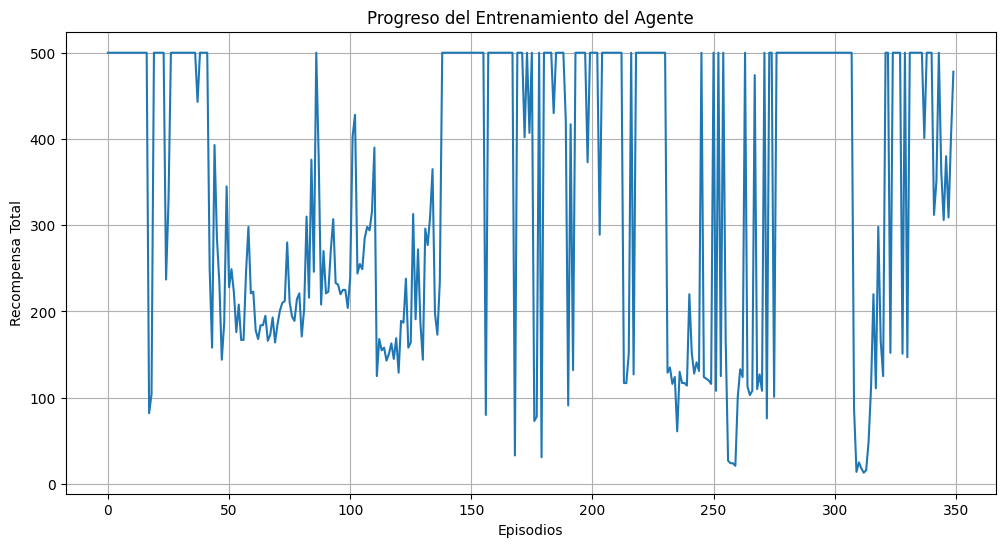

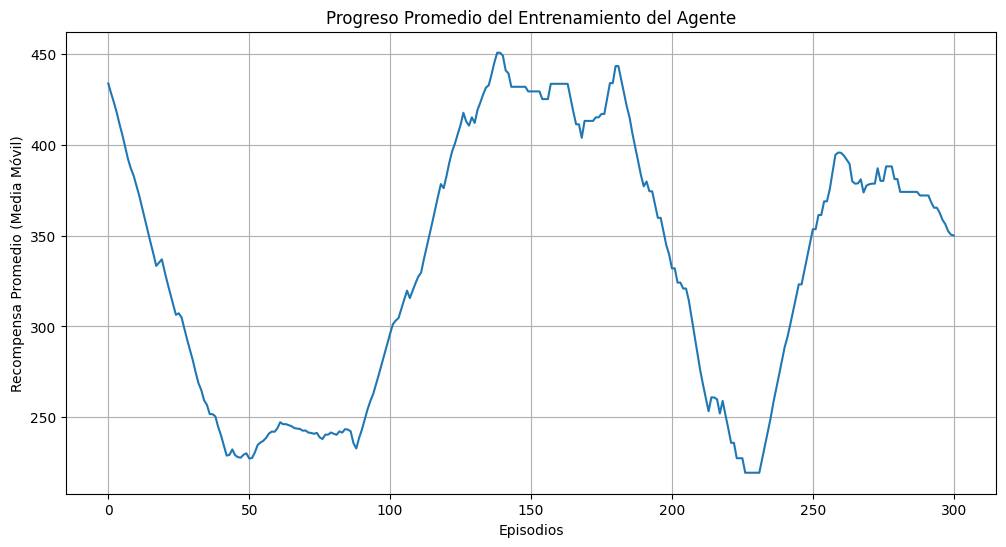

In [20]:
import matplotlib.pyplot as plt


# Graficar la recompensa total por episodio
plt.figure(figsize=(12, 6))
plt.plot(total_rewards)
plt.xlabel('Episodios')
plt.ylabel('Recompensa Total')
plt.title('Progreso del Entrenamiento del Agente')
plt.grid(True)
plt.show()

# Graficar la recompensa promedio usando media móvil
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

window_size = 50  # Tamaño de la ventana para la media móvil
ma_rewards = moving_average(total_rewards, window_size)

plt.figure(figsize=(12, 6))
plt.plot(ma_rewards)
plt.xlabel('Episodios')
plt.ylabel('Recompensa Promedio (Media Móvil)')
plt.title('Progreso Promedio del Entrenamiento del Agente')
plt.grid(True)
plt.show()

In [24]:
# Rendimiento del modelo

import numpy as np

# Calcular estadísticas
mean_reward = np.mean(total_rewards)
std_reward = np.std(total_rewards)
max_reward = np.max(total_rewards)
min_reward = np.min(total_rewards)

print("\nResultados del Entrenamiento:")
print(f"Recompensa Promedio: {mean_reward:.2f}")
print(f"Desviación Estándar: {std_reward:.2f}")
print(f"Recompensa Máxima: {max_reward}")
print(f"Recompensa Mínima: {min_reward}")



Resultados del Entrenamiento:
Recompensa Promedio: 346.00
Desviación Estándar: 167.17
Recompensa Máxima: 500.0
Recompensa Mínima: 13.0


### ✅ Fine Tuning

In [16]:
gamma = 0.98  
epsilon = 1.0 
epsilon_decay = 0.997  
epsilon_min = 0.01  
lr = 0.0005  
batch_size = 128  
memory_size = 20000  
target_update_freq = 5

In [11]:


# Cambiar optimizador a RMSprop, a menudo más adecuado para RL
optimizer = optim.RMSprop(online_net.parameters(), lr=lr)
loss_fn = nn.MSELoss()

# Implementar Double DQN en la actualización de los valores Q objetivo
def update_q_values(replay_buffer, batch_size):
    states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
    
    # Convertir a tensores de PyTorch
    states = torch.FloatTensor(states)
    actions = torch.LongTensor(actions).unsqueeze(1)
    rewards = torch.FloatTensor(rewards)
    next_states = torch.FloatTensor(next_states)
    dones = torch.FloatTensor(dones)
    
    # Calcular los valores Q actuales
    q_values = online_net(states).gather(1, actions).squeeze(1)
    
    # Calcular los valores Q objetivo usando Double DQN
    with torch.no_grad():
        # Usar la red en línea para seleccionar la mejor acción
        next_action = online_net(next_states).argmax(1).unsqueeze(1)
        # Usar la red de destino para calcular el valor Q de esa acción
        next_q_values = target_net(next_states).gather(1, next_action).squeeze(1)
        targets = rewards + gamma * next_q_values * (1 - dones)
    
    # Calcular la pérdida
    loss = loss_fn(q_values, targets)
    
    # Retropropagación y actualización de pesos
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Ciclo de entrenamiento
num_episodes = 1000
max_timesteps = 500
total_rewards = []

for episode in range(num_episodes):
    state, _ = env.reset()
    total_reward = 0
    for t in range(max_timesteps):
        # Seleccionar una acción usando la política epsilon-greedy
        action = epsilon_greedy_action(state, epsilon)
        
        # Ejecutar la acción en el entorno
        next_state, reward, done, truncated, _ = env.step(action)
        total_reward += reward
        
        # Almacenar la experiencia en el buffer de reproducción
        replay_buffer.add((state, action, reward, next_state, done))
        
        # Actualizar el estado actual
        state = next_state
        
        # Si hay suficientes muestras en el buffer, realizar una actualización
        if len(replay_buffer.buffer) >= batch_size:
            update_q_values(replay_buffer, batch_size)
        
        # Si el episodio ha terminado, salir del loop
        if done or truncated:
            break
    
    # Almacenar la recompensa total obtenida en este episodio
    total_rewards.append(total_reward)
    
    # Decaimiento de epsilon
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay
    else:
        epsilon = epsilon_min
    
    # Actualizar la red de destino cada 'target_update_freq' episodios
    if episode % target_update_freq == 0:
        target_net.load_state_dict(online_net.state_dict())
    
    # Imprimir el progreso
    print(f"Episodio {episode}, Recompensa Total: {total_reward}, Epsilon: {epsilon:.4f}")

# Cerrar el entorno al final del entrenamiento
env.close()

Episodio 0, Recompensa Total: 13.0, Epsilon: 0.9970
Episodio 1, Recompensa Total: 20.0, Epsilon: 0.9940
Episodio 2, Recompensa Total: 14.0, Epsilon: 0.9910
Episodio 3, Recompensa Total: 21.0, Epsilon: 0.9881
Episodio 4, Recompensa Total: 27.0, Epsilon: 0.9851
Episodio 5, Recompensa Total: 59.0, Epsilon: 0.9821
Episodio 6, Recompensa Total: 56.0, Epsilon: 0.9792
Episodio 7, Recompensa Total: 18.0, Epsilon: 0.9763
Episodio 8, Recompensa Total: 18.0, Epsilon: 0.9733
Episodio 9, Recompensa Total: 17.0, Epsilon: 0.9704
Episodio 10, Recompensa Total: 26.0, Epsilon: 0.9675
Episodio 11, Recompensa Total: 17.0, Epsilon: 0.9646
Episodio 12, Recompensa Total: 11.0, Epsilon: 0.9617
Episodio 13, Recompensa Total: 11.0, Epsilon: 0.9588
Episodio 14, Recompensa Total: 35.0, Epsilon: 0.9559
Episodio 15, Recompensa Total: 16.0, Epsilon: 0.9531
Episodio 16, Recompensa Total: 57.0, Epsilon: 0.9502
Episodio 17, Recompensa Total: 25.0, Epsilon: 0.9474
Episodio 18, Recompensa Total: 13.0, Epsilon: 0.9445
Epi

In [12]:
epsilon = 0.0
for episode in range(5):
    state, _ = env.reset()
    total_reward = 0
    for t in range(max_timesteps):
        action = epsilon_greedy_action(state, epsilon)
        next_state, reward, done, truncated, _ = env.step(action)
        total_reward += reward
        state = next_state
        if done or truncated:
            break
    print(f"Evaluación - Episodio {episode}, Recompensa Total: {total_reward}")


Evaluación - Episodio 0, Recompensa Total: 500.0
Evaluación - Episodio 1, Recompensa Total: 500.0
Evaluación - Episodio 2, Recompensa Total: 500.0
Evaluación - Episodio 3, Recompensa Total: 500.0
Evaluación - Episodio 4, Recompensa Total: 500.0


In [13]:
# Representar el entorno

env = gym.make('CartPole-v1', render_mode='human')

# Definir el optimizador y la función de pérdida
optimizer = optim.Adam(online_net.parameters(), lr=lr)
loss_fn = nn.MSELoss()

# Número de episodios y pasos máximos por episodio
num_episodes = 350
max_timesteps = 500

# Lista para almacenar las recompensas totales por episodio
total_rewards = []

for episode in range(num_episodes):
    # Controlar el renderizado: renderizar cada 100 episodios
    render = True if episode % 100 == 0 else False
    if render:
        print(f"Renderizando el episodio {episode}")

    state, _ = env.reset()
    total_reward = 0
    for t in range(max_timesteps):
        if render:
            env.render()

        # Seleccionar una acción usando la política epsilon-greedy
        action = epsilon_greedy_action(state, epsilon)
        
        # Ejecutar la acción en el entorno
        next_state, reward, done, truncated, _ = env.step(action)
        total_reward += reward
        
        # Almacenar la experiencia en el buffer de reproducción
        replay_buffer.add((state, action, reward, next_state, done))
        
        # Actualizar el estado actual
        state = next_state
        
        # Si hay suficientes muestras en el buffer, realizar una actualización
        if len(replay_buffer.buffer) >= batch_size:
            # Muestrear un batch de experiencias
            states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
            
            # Convertir a tensores de PyTorch
            states = torch.FloatTensor(states)
            actions = torch.LongTensor(actions).unsqueeze(1)
            rewards = torch.FloatTensor(rewards)
            next_states = torch.FloatTensor(next_states)
            dones = torch.FloatTensor(dones)
            
            # Calcular los valores Q actuales
            q_values = online_net(states).gather(1, actions).squeeze(1)
            
            # Calcular los valores Q objetivo usando la red de destino
            with torch.no_grad():
                next_q_values = target_net(next_states).max(1)[0]
                targets = rewards + gamma * next_q_values * (1 - dones)
            
            # Calcular la pérdida
            loss = loss_fn(q_values, targets)
            
            # Retropropagación y actualización de pesos
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Si el episodio ha terminado, salir del loop
        if done or truncated:
            break
    
    # Almacenar la recompensa total obtenida en este episodio
    total_rewards.append(total_reward)
    
    # Decaimiento de epsilon
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay
    else:
        epsilon = epsilon_min
    
    # Actualizar la red de destino cada 'target_update_freq' episodios
    if episode % target_update_freq == 0:
        target_net.load_state_dict(online_net.state_dict())
    
    # Imprimir el progreso
    print(f"Episodio {episode}, Recompensa Total: {total_reward}, Epsilon: {epsilon:.4f}")

# Cerrar el entorno al final del entrenamiento
env.close()


Renderizando el episodio 0
Episodio 0, Recompensa Total: 500.0, Epsilon: 0.0100
Episodio 1, Recompensa Total: 500.0, Epsilon: 0.0100
Episodio 2, Recompensa Total: 500.0, Epsilon: 0.0100
Episodio 3, Recompensa Total: 500.0, Epsilon: 0.0100
Episodio 4, Recompensa Total: 500.0, Epsilon: 0.0100
Episodio 5, Recompensa Total: 500.0, Epsilon: 0.0100
Episodio 6, Recompensa Total: 500.0, Epsilon: 0.0100
Episodio 7, Recompensa Total: 199.0, Epsilon: 0.0100
Episodio 8, Recompensa Total: 330.0, Epsilon: 0.0100
Episodio 9, Recompensa Total: 297.0, Epsilon: 0.0100
Episodio 10, Recompensa Total: 264.0, Epsilon: 0.0100
Episodio 11, Recompensa Total: 339.0, Epsilon: 0.0100
Episodio 12, Recompensa Total: 500.0, Epsilon: 0.0100
Episodio 13, Recompensa Total: 360.0, Epsilon: 0.0100
Episodio 14, Recompensa Total: 452.0, Epsilon: 0.0100
Episodio 15, Recompensa Total: 500.0, Epsilon: 0.0100
Episodio 16, Recompensa Total: 227.0, Epsilon: 0.0100
Episodio 17, Recompensa Total: 500.0, Epsilon: 0.0100
Episodio 18

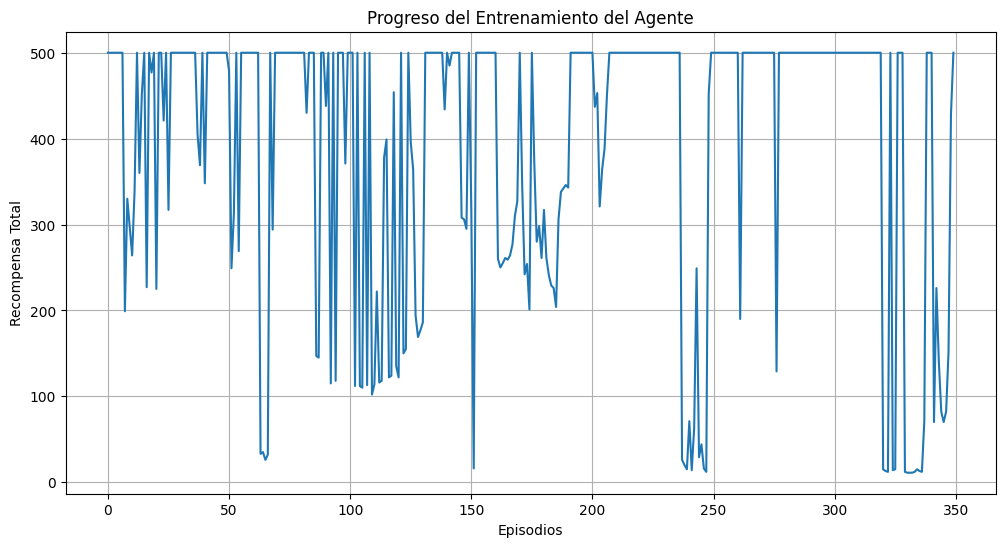

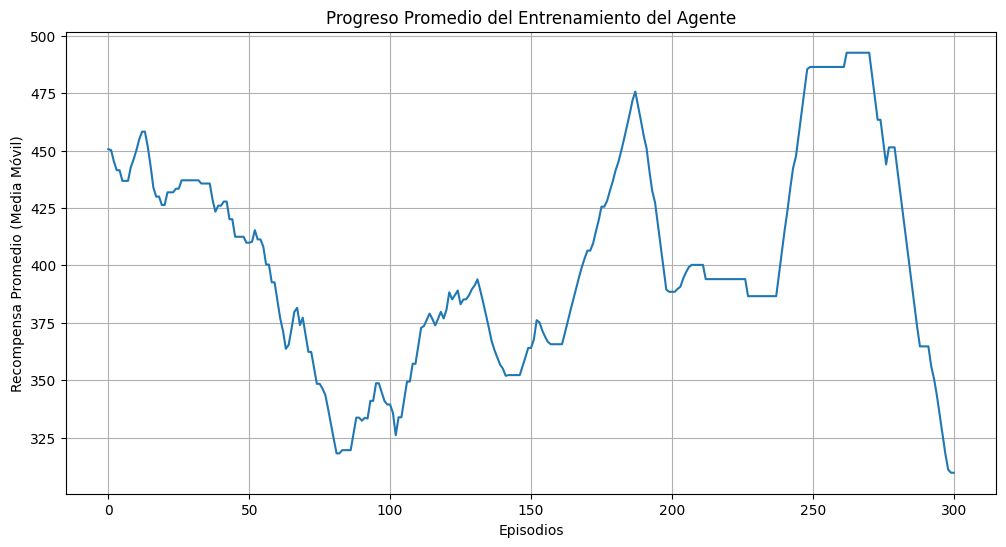

In [14]:
import matplotlib.pyplot as plt


# Graficar la recompensa total por episodio
plt.figure(figsize=(12, 6))
plt.plot(total_rewards)
plt.xlabel('Episodios')
plt.ylabel('Recompensa Total')
plt.title('Progreso del Entrenamiento del Agente')
plt.grid(True)
plt.show()

# Graficar la recompensa promedio usando media móvil
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

window_size = 50  # Tamaño de la ventana para la media móvil
ma_rewards = moving_average(total_rewards, window_size)

plt.figure(figsize=(12, 6))
plt.plot(ma_rewards)
plt.xlabel('Episodios')
plt.ylabel('Recompensa Promedio (Media Móvil)')
plt.title('Progreso Promedio del Entrenamiento del Agente')
plt.grid(True)
plt.show()

In [15]:
# Rendimiento del modelo

import numpy as np

# Calcular estadísticas
mean_reward = np.mean(total_rewards)
std_reward = np.std(total_rewards)
max_reward = np.max(total_rewards)
min_reward = np.min(total_rewards)

print("\nResultados del Entrenamiento:")
print(f"Recompensa Promedio: {mean_reward:.2f}")
print(f"Desviación Estándar: {std_reward:.2f}")
print(f"Recompensa Máxima: {max_reward}")
print(f"Recompensa Mínima: {min_reward}")


Resultados del Entrenamiento:
Recompensa Promedio: 392.66
Desviación Estándar: 163.39
Recompensa Máxima: 500.0
Recompensa Mínima: 11.0


Como comentario final, para el fine tuning básicamente se hizo una pequeña variación de hiperparámetros, un cambio de optimizador a RMSprop, el cual se puede adecuar mejor a un learning rate e implementar una Double DQN en la actualizacipon de los valores Q objetvo.

Ambos entrenamientos duraron casi el mismo tiempo, pero en términos de recompensa promedio, podemos ver que el último modelo tiene una recompensa promedio más alta, lo que indica un mejor desempeño en general. También tiene una desviación estandar ligeramente menor, lo que nos dice que el comportamiento es más consistente. Finalmente con recompensas mínimas y máximas ambos modelos alcanzan la recompensa máxima de 500 pero este último tiene una recompensa mínima mennor, lo que puede indicar que en algunos episodios tiene peor desempeño en comparación al primer modelo. Es posible que haga falta un early stopping, lo cual puede ayudar en este aspecto, pero en general, el modelo con fine tuning fue mejorado, lo que se buscaba en un incio.

## 💻 Task 2

Defina en qué consiste y en qué clase de problemas se pueden usar cada uno de los siguientes acercamientos en Deep Reinforcement Learning:

**1. Proximal Policy Optimization**

Es un algoritmo de aprendizaje por refuerzo que busca optimizar directamente la política del agente. Su principal característica es que limita los cambios en la política entre actualizaciones, loque mejora la estabilidad del aprendizaje. Se puede utilizar en tareas de control robótico, juegos complejos como videojuegos.

**2. Deep Deterministic Policy Gradients (DDPG)**

Es un algoritmo off-policy que combina ideas de DQN y deterministic policy gradients. Utiliza una red de actor para determinar acciones y una red de crítico para evaluar esas acciones. Se puede aplicar en control de robots, vehíxulos autonomos y drones, problemas donde se requiere presición en el control.

**3. Trust Region Policy Optimization (TRPO)**

Es un algoritmo que busca mejorar la política del agente mientras garantiza que los cambios en la política no sean demasisado grandes. Usa restricción de región de confianza para limpiar el tamaño de las actualizaciones de la política. Se puede aplicar igualmente en tareas de control robótico más complejas, problemas donde se busca evitar colapsos catastróficos en el rendimiento y situaciones donde se necesite una buena estabilidad del aprendizaje.

**4. Asynchronous Advantage Actor-Critic (A3C)**

Es un algoritmo que utiliza múltiples agentes trabajando en paralelo para explorar diferentes partes del entorno. Cada agente actualiza de forma asíncrona una red global compartida, loq ue acelera y estabiliza el aprendizaje. Se utilia en juegos y simulaciones complejas, tareas idbde se necesita una exploración eficiente del entorno y se busque reducir el tiempo de entrenamiento.